In [8]:
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore, get_types_from_msg


from pathlib import Path
from glob import glob
from pid_controller import DESIRED_ANGLE

import numpy as np
import matplotlib.pyplot as plt

def get_lean_data (path):
    data = []
    timestamps = []
    typestore = get_typestore(Stores.ROS2_HUMBLE)
    with Reader(path) as reader:
        connections = [x for x in reader.connections if x.topic == '/output/lean_angle']
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            timestamps.append(timestamp)
            data.append(msg.data)

    np_data = np.array(data)
    np_time = (np.array(timestamps) - timestamps[0]) / 1e9
    return np_data, np_time

def get_tune_data (path):
    data = []
    timestamps = []
    typestore = get_typestore(Stores.ROS2_HUMBLE)
    with Reader(path) as reader:
        connections = [x for x in reader.connections if x.topic == '/output/tuning_values']
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            timestamps.append(timestamp)
            data.append(msg.data)

    np_data = np.array(data)
    np_time = (np.array(timestamps) - timestamps[0]) / 1e9
    return np_data, np_time

/tmp/ipykernel_2830/3521404321.py:9: DeprecationWarning: Global type registration has been replaced with explicit typestores.

Perform all type registration and subsequent serialization and
deserialization on typestore instances:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.register(types)
  register_types(get_types_from_msg(TUNE_MSG, 'beep_interfaces/msg/TuningValues'))


ImportError: cannot import name 'beep_interfaces__msg__TuningValues' from 'rosbags.typesys.types' (/home/orin/.local/lib/python3.10/site-packages/rosbags/typesys/types.py)

In [6]:
bags = glob("../bags/*")
bags.sort()

path = Path(bags[-1])
prev_path = Path(bags[-2])

data, time = get_lean_data(path)
prev_data, prev_time = get_lean_data(prev_path)

tune_data, tune_time = get_tune_data(path)

print(tune_data[0])

print(data.shape)
print(time.shape)

KeyError: 'beep_interfaces/msg/TuningValues'

Text(0, 0.5, 'Error (rad)')

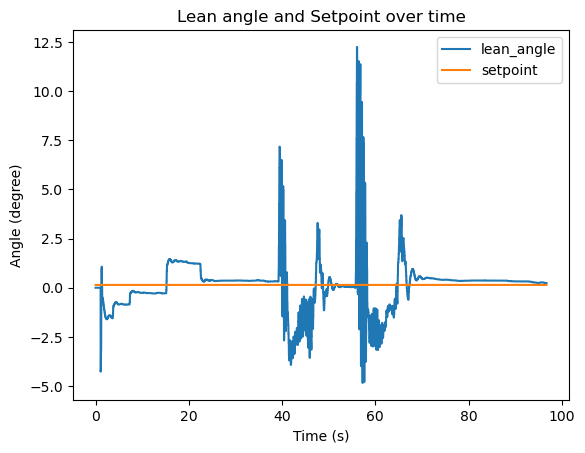

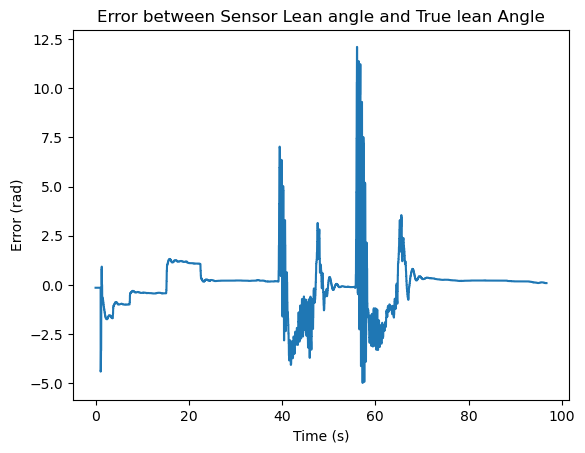

In [3]:


setpoint = DESIRED_ANGLE
setpoint_array = np.ones(data.shape) * setpoint

#graph 1
plt.figure()
plt.plot(time, data)
plt.plot(time, setpoint_array)

plt.title("Lean angle and Setpoint over time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degree)")
plt.legend(["lean_angle", "setpoint"])

plt.figure()
plt.plot(time, data-setpoint_array)

plt.title("Error between Sensor Lean angle and True lean Angle")
plt.xlabel("Time (s)")
plt.ylabel("Error (rad)")

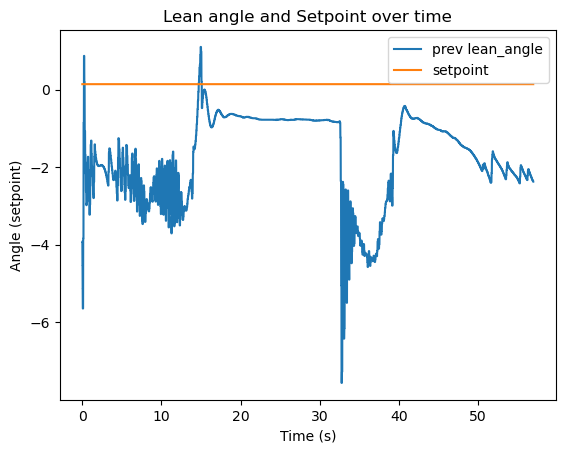

In [23]:
#graph 2
plt.figure()
plt.plot(prev_time, prev_data)
plt.plot(prev_time, np.ones(prev_time.shape) * setpoint)

plt.title("Lean angle and Setpoint over time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (setpoint)")
plt.legend(["prev lean_angle", "setpoint"])